#### Import libraries and packages

In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import shapely
import ee, geemap, eemont
import json
import geojson

In [2]:
ee.Authenticate()
ee.Initialize()

#### Load satellite dataset and fire preimeter

Copernicus Sentinel-2 (COPERNICUS/S2_SR_HARMONIZED) data involves using the surface reflectance information in the data to calculate spectral indices like the Normalized Burn Ratio (NBR) or specialized indices like BADI, or employing machine learning algorithms with spectral and textural features to distinguish burned areas from other land cover changes.



data source: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/explore?location=37.187645%2C-120.227660%2C5.95

tutorials: https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine

In [3]:
%cd pc

/csghome/sm330/pc


In [4]:
in_file = f"data/California_Historic_Fire_Perimeters.geojson"

In [5]:
fire_gdf = gpd.read_file(in_file)
fire_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      22810 non-null  int32   
 1   YEAR_         22733 non-null  float64 
 2   STATE         22810 non-null  object  
 3   AGENCY        22761 non-null  object  
 4   UNIT_ID       22749 non-null  object  
 5   FIRE_NAME     22748 non-null  object  
 6   INC_NUM       21839 non-null  object  
 7   ALARM_DATE    17414 non-null  object  
 8   CONT_DATE     10180 non-null  object  
 9   CAUSE         22810 non-null  int32   
 10  C_METHOD      10708 non-null  float64 
 11  OBJECTIVE     22539 non-null  float64 
 12  GIS_ACRES     22810 non-null  float64 
 13  COMMENTS      2835 non-null   object  
 14  COMPLEX_NAME  611 non-null    object  
 15  IRWINID       3736 non-null   object  
 16  FIRE_NUM      17642 non-null  object  
 17  COMPLEX_ID    567 non-null    object  
 18

In [ ]:
fire_gdf.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198..."
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009..."
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,7.0,1.0,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585..."
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,2.0,1.0,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,7.0,1.0,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3..."


The dataset includes the year of fires, the occurance place, fire name, alarm and containment date



We chose the fires that occured during 2024-2025, perform statistical analysis to find the time window within each year

Prepare the ground truth for fire area detection on the satellite imagery, by comparing the pre and post fire (before the time window and after the window)

2020
2021
2022
2023
2024
2025

In [6]:
fire_df = pd.DataFrame(fire_gdf)
fire_df["ALARM_DATE_ISO"] = pd.to_datetime(fire_df.ALARM_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')
fire_df["CONT_DATE_ISO"]  = pd.to_datetime(fire_df.CONT_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [7]:
fire_df.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry,ALARM_DATE_ISO,CONT_DATE_ISO
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198...",2025-01-07T08:00:00Z,2025-01-31T08:00:00Z
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009...",2025-01-08T08:00:00Z,2025-01-31T08:00:00Z
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,...,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585...",2025-01-22T08:00:00Z,2025-01-28T08:00:00Z
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,...,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16...",2025-01-09T08:00:00Z,2025-02-04T08:00:00Z
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,...,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3...",2025-01-07T08:00:00Z,2025-01-09T08:00:00Z


<AxesSubplot: >

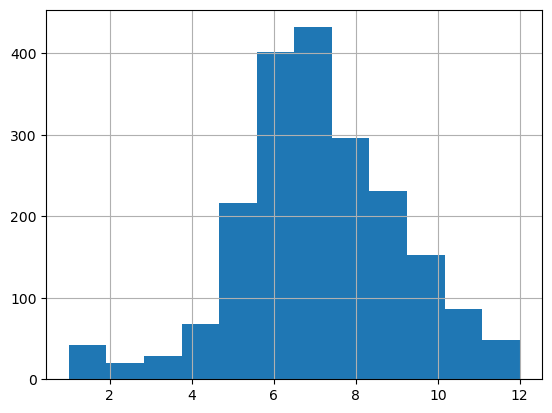

In [ ]:
fire_df.query("DECADES == '2020-January 2025'").CONT_DATE_NEW.dt.month.hist(bins=12)

<AxesSubplot: >

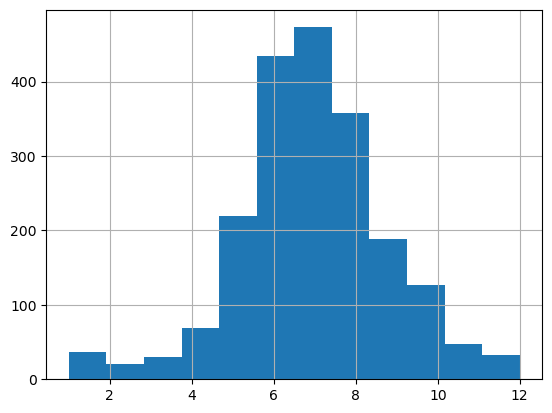

In [ ]:
fire_df.query("DECADES == '2020-January 2025'").ALARM_DATE_NEW.dt.month.hist(bins=12)

#### Select study area, time frame and create cloud mask

In [ ]:
fire_gdf.DECADES.unique()

array(['2020-January 2025', '2010-2019', '2000-2009', '1990-1999',
       '1980-1989', '1970-1979', '1960-1969', '1950-1959', None],
      dtype=object)

### Filter recently five years

In [8]:
aoi = fire_gdf[fire_gdf.DECADES == "2020-January 2025"]

In [9]:
aoi = gpd.GeoDataFrame(aoi)

In [ ]:
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2036 entries, 0 to 2035
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      2036 non-null   int32   
 1   YEAR_         2036 non-null   float64 
 2   STATE         2036 non-null   object  
 3   AGENCY        2036 non-null   object  
 4   UNIT_ID       2035 non-null   object  
 5   FIRE_NAME     2036 non-null   object  
 6   INC_NUM       2031 non-null   object  
 7   ALARM_DATE    2036 non-null   object  
 8   CONT_DATE     2022 non-null   object  
 9   CAUSE         2036 non-null   int32   
 10  C_METHOD      2036 non-null   float64 
 11  OBJECTIVE     2003 non-null   float64 
 12  GIS_ACRES     2036 non-null   float64 
 13  COMMENTS      409 non-null    object  
 14  COMPLEX_NAME  59 non-null     object  
 15  IRWINID       1901 non-null   object  
 16  FIRE_NUM      0 non-null      object  
 17  COMPLEX_ID    55 non-null     object  
 18  DECAD

In [10]:
geojson = geojson.loads(aoi.to_json())

<AxesSubplot: >

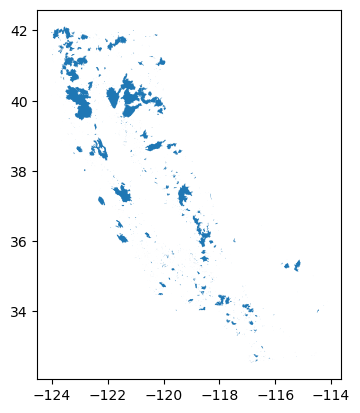

In [11]:
aoi.geometry.plot()   ## 2020-2025

In [12]:
geom = geemap.geopandas_to_ee(aoi)

#### Query ad filter image collections

In [24]:
OUT_FOLDER = "earthengine"
SCALE = 20
MAX_PIXELS = 1e13
PRE_DAYS_MIN = 30
PRE_DAYS_MAX = 120
POST_DAYS_AFTER_CONTAIN = 30
CLOUD_THRESHOLD = 10

In [25]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [26]:
START_DATE = "2024-01-01"
END_DATE = "2025-09-01"
start = ee.Date(START_DATE)
end = ee.Date(END_DATE)

In [31]:
perims = ee.FeatureCollection(geojson)

In [27]:
AOI = ee.Geometry.BBoxFromQuery("California, United States", user_agent = "RS_course")

In [29]:
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(AOI)
    .filterDate(start, end)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD))
    .map(mask_s2_clouds)
)

In [30]:
def get_monthly_composite(year, month, collection, AOI):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    monthly_col = collection.filterDate(start, end)

    # Take median to reduce cloud/shadow effects
    monthly_img = monthly_col.median().clip(AOI)

    return monthly_img

In [35]:
def get_month_mask(perims, start, end, AOI):
    fires_in_month = perims.filter(
        ee.Filter.And(
            ee.Filter.gte('CONT_DATE_ISO', start),
            ee.Filter.lt('CONT_DATE_ISO', end)
        )
    )
    mask = ee.Image(0).byte().paint(fires_in_month, 1).clip(AOI)
    return mask.rename('mask')

In [36]:
start = ee.Date('2024-01-01')
end   = start.advance(1, 'month')

monthly_img = get_monthly_composite(2024, 1, collection, AOI)
mask = get_month_mask(perims, start, end, AOI)

stack = monthly_img.addBands(mask)

In [37]:
nbr = monthly_img.normalizedDifference(['B8', 'B12']).rename('NBR')
stack = stack.addBands(nbr)

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=stack.toFloat(),
    description='fire_segmentation_Jan2025',
    folder='earthengine',
    fileNamePrefix='fire_Jan2025',
    region=AOI.bounds(),
    scale=20,
    maxPixels=1e13
)
task.start()
